# Introduction

In the previous four lessons, you learned about several fundamental time series concepts including stationarity, smoothing, trend, seasonality, and autocorrelation, and you built two different kinds of models: 

  * **MA models**: Specify that the current value of the series depends linearly on the series' mean and a set of prior (observed) white noise error terms.
  * **AR models**: Specify that the current value of the  series depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term).

In the current lesson we will review thes concepts as well as combine these two model types into three more complicated time series models: ARMA, ARIMA, and SARIMA.

# Learning Outcomes
You should walk away from this tutorial with:
1. A practical understanding of Autoregressive Moving Average (ARMA) models.
2. A basic understanding of the Autocorrelation Function (ACF).
3. Insight into choosing the order *q* of MA models.
4. A practical understanding of Autoregressive (AR) models.
5. A basic understanding of the Partial Autocorrelation Function (PACF).
6. Insight into choosing the order *p* of AR models.

# Imports

In [3]:
!pip install pyflux

    100% |████████████████████████████████| 1.3MB 575kB/s ta 0:00:011
    100% |████████████████████████████████| 3.2MB 1.4MB/s ta 0:00:011
    100% |████████████████████████████████| 194kB 2.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for pyflux ... done
  Stored in directory: /Users/edima/Library/Caches/pip/wheels/36/24/09/d18fa4f926cc90598d23ebd09fb4b0fd7b3dd1d2f506b952de
  Running setup.py bdist_wheel for algopy ... done
  Stored in directory: /Users/edima/Library/Caches/pip/wheels/58/08/1a/722554a81c38724475372972cd0e50081ec63c7a58e3c48fa8
Successfully built pyflux algopy
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
%matplotlib inline

from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyflux as pf
import statsmodels as ss
import seaborn as sns
import sys
import warnings

# Python & Library Versions

In [5]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("pyflux", pf.__version__),
            ("seaborn", sns.__version__),
            ("statsmodels", ss.__version__) )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

('2.7.15 |Anaconda, Inc.| (default, May  1 2018, 18:37:05) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]', '\n')
library    version
------------------
matplotlib  2.2.2
numpy       1.14.3
pandas      0.23.0
pyflux      0.4.15
seaborn     0.8.1
statsmodels 0.9.0


---

# Section 1: Time Series Review

We've covered lots of material in the previous four lessons. Now is a good time to step back and rehash what we've covered. This will help to both solidify concepts and ensure you're ready to tackle ARMA, ARIMA, and SARIMA models.

### Section 1.1: Examples of time series data and modeling:
- Hedge fund prediction of stock and index movements
- Long and short-term weather forecasting
- Business budgeting and trend analysis
- Health vitals monitoring
- Traffic flows and logistic optimization modeling
- Can you think of others?

### Section 1.2: Decomposition
Time series data can often be decomposed into trend, seasonal, and random fluctuation components.

![Decomposition](http://rstatistics.net/wp-content/uploads/2014/09/Multiplicative-Decomposition-of-Time-series.png)

- Trends
    - Up
    - Down
    - Flat
    - Larger trends can be made up of smaller trends
    - There is no defined timeframe for what constitutes a trend as it depends on your goals
- Seasonal Effects
    - Weekend retail sales spikes
    - Holiday shopping
    - Energy requirement changes with annual weather patterns
    - Note: Twitter spikes when news happens are not seasonal because they aren't regular and predictable
- Random Fluctuations
    - The human element
    - Aggregations of small influencers
    - Observation errors
    - The smaller this is in relation to Trend and Seasonal, the better we can predict the future

### Section 1.3: Additive vs Multiplicative
Time series models fall into [two camps](http://www.abs.gov.au/websitedbs/D3310114.nsf/home/Time+Series+Analysis:+The+Basics#HOW%20DO%20I%20KNOW%20WHICH%20DECOMPOSITION):
- Additive
    - Data = Trend + Seasonal + Random
    - What we will be using for our modeling
- Multiplicative
    - Data = Trend x Seasonal x Random
    - As easy to fit as Additive if we take the log
        - log(Data) = log(Trend x Seasonal x Random)

We should use multiplicative models when the percentage change of our data is more important than the absolute value change (e.g. stocks, commodities); as the trend rises and our values grow, we see amplitude growth in seasonal and random fluctuations. If our seasonality and fluctuations are stable, we likely have an additive model.

### Section 1.4: Time Series Modeling Process
Time series model selection is driven by the Trend and Seasonal components of our raw data. The general approach for analysis looks like this:

1. Plot the data and determine Trends and Seasonality
    1. Difference or take the log of the data (multiple times if needed) to remove trends for [certain model applications](https://en.wikipedia.org/wiki/Stationary_process)
    1. Stationairity is needed for ARMA models
1. Determine if we have additive or multiplicative data patterns
1. Select the appropriate algorithm based on the chart below
1. Determine if model selection is correct with these tools
    - Ljung-Box Test
    - Residual Errors (Normal Distribution with zero mean and constant variance-homoskedastic, i.i.d)
    - Autocorrelation Function (ACF)
    - Partial Autocorrelation Function (PACF)

Algorithm | Trend | Seasonal | Correlations
---|---|---|---
ARIMA | X |X|X
SMA Smoothing |X||
Simple Exponential Smoothing |X||
Seasonal Adjustment |X|X|
Holt's Exponential Smoothing |X||
Holt-Winters |X|X|

### Section 1.5: How to Achieve and Test for Stationarity
- The mean of the series is not a function of time.

- The variance of the series is not a function of time (homoscedasticity).

- The covariance at different lags is not a function of time.

[From A Complete Tutorial on Time Series Modeling in R](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

- [Info on stationarity](http://www.investopedia.com/articles/trading/07/stationary.asp)
- Plotting Rolling Statistics
    - Plot the moving average/variance and see if it changes with time. This visual technique can be done on different windows, but isn't as rigorously defensible as the test below.
- Augmented Dickey-Fuller Test
    - Statistical tests for checking stationarity; the null hypothesis is that the TS is non-stationary. If our test statistic is below an `alpha` value, we _can_ reject the null hypothesis and say that the series is stationary.
    
    $$ Y_t = \rho * Y_{t-1} + \epsilon_t $$
    
    $$ Y_t - Y_{t-1} = (\rho - 1) Y_{t - 1} + \epsilon_t $$
    
### Section 1.6: Differencing Example

In [6]:
# create a play dataframe from 1-10 (linear and squared) to test how differencing works
play = pd.DataFrame([[x for x in range(1,11)], [x**2 for x in range(1,11)]]).T
play.columns = ['original', 'squared']
play

,original,squared
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25
5,6,36
6,7,49
7,8,64
8,9,81
9,10,100


In [7]:
# stationarize linear series (mean and variance don't change for sub-windows)
play.original.diff()

0    NaN
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: original, dtype: float64

**NOTE:** This is similar to taking a first-order derivative.

In [8]:
# stationarize squared series
play.squared.diff().diff()

0    NaN
1    NaN
2    2.0
3    2.0
4    2.0
5    2.0
6    2.0
7    2.0
8    2.0
9    2.0
Name: squared, dtype: float64

**NOTE:** Notice we need to difference twice on an exponential trend, and every time we do, we lose a bit of data

In [9]:
# stationarize squared with log
np.log(play.squared)

0    0.000000
1    1.386294
2    2.197225
3    2.772589
4    3.218876
5    3.583519
6    3.891820
7    4.158883
8    4.394449
9    4.605170
Name: squared, dtype: float64

**NOTE:** Works somewhat but certainly not as well.

## Data Prep and EDA

We'll be looking at [monthly average temperatures between 1907-1972](https://datamarket.com/data/set/22o4/mean-monthly-temperature-1907-1972#!ds=22o4&display=line)

In [10]:
# load data and convert to datetime
monthly_temp = pd.read_csv('../Data/mean-monthly-temperature-1907-19.csv', 
                           skipfooter=2, 
                           infer_datetime_format=True, 
                           header=0, 
                           index_col=0, 
                           names=['month', 'temp'])

monthly_temp.index = pd.to_datetime(monthly_temp.index)

In [11]:
monthly_temp.head()

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8


In [12]:
# describe
monthly_temp.describe()

,temp
count,792.000000
mean,53.553662
std,15.815452
min,11.200000
25%,39.675000
50%,52.150000
75%,67.200000
max,82.400000


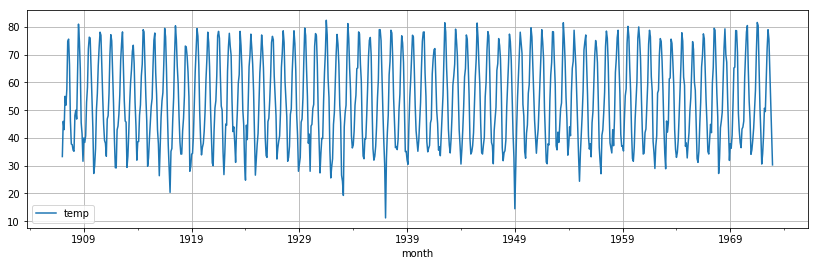

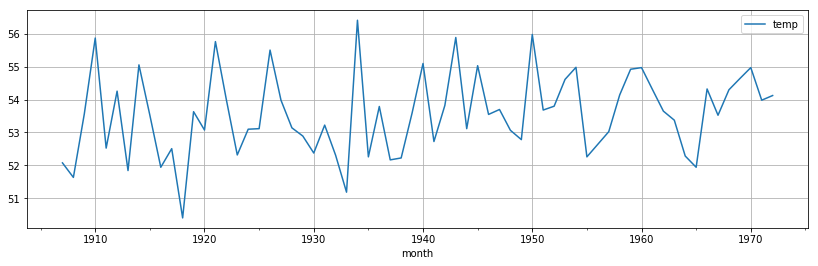

In [13]:
# resample to annual and plot each
plt.rcParams['figure.figsize'] = [14, 4]
annual_temp = monthly_temp.resample('A').mean()
monthly_temp.plot(grid=True)
annual_temp.plot(grid=True);

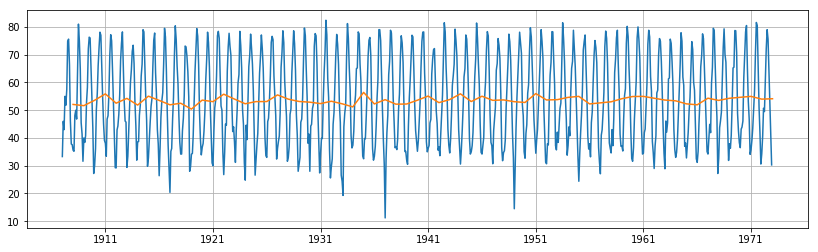

In [14]:
# plot both on same figure
plt.plot(monthly_temp)
plt.plot(annual_temp)
plt.grid();

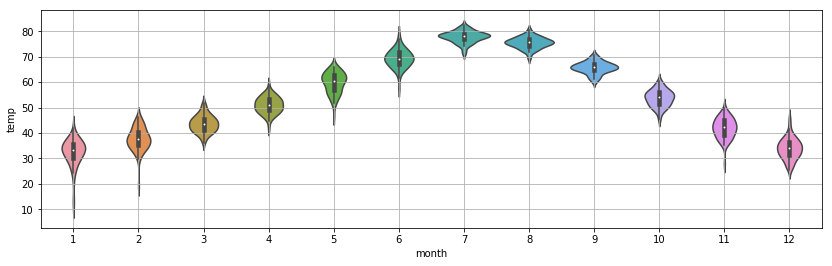

In [15]:
# violinplot of months to determine variance and range
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp)
plt.grid();

Are these datasets stationary? We can look at a few things per the list above, including a visual check (there seems to be a small upward trend in the annual, too hard to tell for monthly), a standard deviation check on various differences (smallest one is usually most stationary), and the formal Dickey-Fuller test.

In [16]:
# check montly deviations for various diffs
print(monthly_temp.temp.std())
print(monthly_temp.temp.diff().std())
print(monthly_temp.temp.diff().diff().std()) # theoretically lowest, but > 1 is close enough
print(monthly_temp.temp.diff().diff().diff().std())

15.8154515407
9.45542698779
9.25220062434
14.7261507868


In [17]:
# check annual deviations for various diffs
print(annual_temp.temp.std()) # looks stationary as is
print(annual_temp.temp.diff().std())
print(annual_temp.temp.diff().diff().std())
print(annual_temp.temp.diff().diff().diff().std())

1.2621242174
1.77256073365
3.11784161381
5.80323210941


In [18]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic         -6.481466e+00
p-value                 1.291867e-08
Lags Used               2.100000e+01
Observations Used       7.700000e+02
Critical Value (5%)    -2.865301e+00
Critical Value (1%)    -3.438871e+00
Critical Value (10%)   -2.568773e+00
dtype: float64


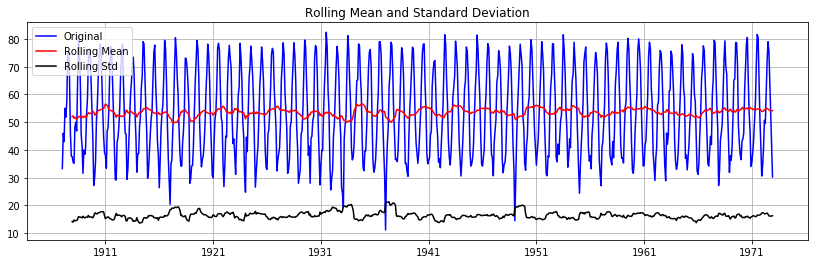

In [19]:
# run DFT on monthly
dftest(monthly_temp.temp)
# p-value allows us to reject a unit root: data is stationary

Test Statistic         -7.878242e+00
p-value                 4.779473e-12
Lags Used               0.000000e+00
Observations Used       6.500000e+01
Critical Value (5%)    -2.907154e+00
Critical Value (1%)    -3.535217e+00
Critical Value (10%)   -2.591103e+00
dtype: float64


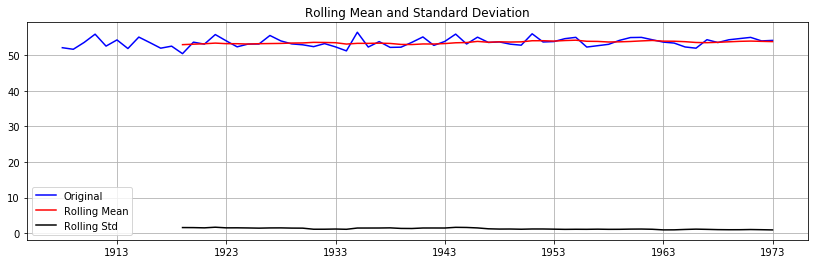

In [20]:
# run DFT on annual
dftest(annual_temp.temp)

The p-value allows us to *reject* a unit root (i.e. the data is stationary).

Test Statistic          -0.449458
p-value                  0.901508
Lags Used               10.000000
Observations Used       55.000000
Critical Value (5%)     -2.915731
Critical Value (1%)     -3.555273
Critical Value (10%)    -2.595670
dtype: float64


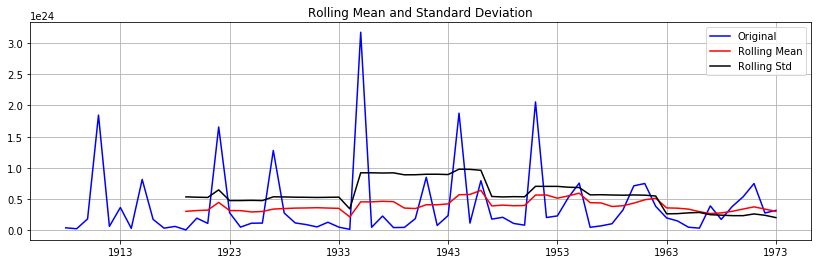

In [21]:
# here's an example of non-stationary with DFT results
dftest(np.exp(annual_temp.temp))

### NOTES

One of the key concepts in the quantitative toolbox is that of mean reversion. This process refers to a time series that displays a tendency to revert to its historical mean value. Mathematically, such a (continuous) time series is referred to as an Ornstein-Uhlenbeck process. This is in contrast to a random walk (aka Brownian motion), which has no "memory" of where it has been at each particular instance of time. The mean-reverting property of a time series can be exploited in order to produce better predictions.

A continuous mean-reverting time series can be represented by an Ornstein-Uhlenbeck stochastic differential equation:

$dx_{t} = θ(μ−x_{t})dt + σdW_{t}$
 
Where: 
- θ is the rate of reversion to the mean, 
- μ is the mean value of the process, 
- σ is the variance of the process and 
- $W_{t}$ is a Wiener Process or Brownian Motion.

In a discrete setting the equation states that the change of the price series in the next time period is proportional to the difference between the mean price and the current price, with the addition of Gaussian noise.

This property motivates the Augmented Dickey-Fuller Test, which we will describe below.

https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing

## Section 2: ARIMA with Statsmodels

Enter [Autoregressive Integrated Moving Average (ARIMA)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) modeling. When we have autocorrelation between outcomes and their ancestors, we will see a theme, or relationship in the outcome plot. This relationship can be modeled in its own way, allowing us to predict the future with a confidence level commensurate to the strength of the relationship and the proximity to known values (prediction weakens the further out we go).

- [ARIMA in R](https://www.otexts.org/fpp/8/5)
- [Duke ARIMA Guide](https://people.duke.edu/~rnau/411arim2.htm)
- [Great explanation on MA in practice](http://stats.stackexchange.com/questions/164824/moving-average-ma-process-numerical-intuition)

### Autoregressive Models

*Autocorrelation:* a variable's correlation with itself at different lags.

For second-order stationary (both mean and variance: $\mu_t = \mu$ and $\sigma_t^2 = \sigma^2$ for all $t$) data, autocovariance is expressed as a function only of the time lag $k$:

$$ \gamma_k = E[(x_t-\mu)(x_{t+k} - \mu)] $$
  
Therefore, the autocorrelation function is defined as:

$$ \rho_k = \frac{\gamma_k}{\sigma^2} $$
  
We use the plot of these values at different lags to determine optimal ARIMA parameters. Notice how `phi` changes the process.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/ArTimeSeries.svg/685px-ArTimeSeries.svg.png)
By Tomaschwutz - Own work, CC BY 3.0, https://commons.wikimedia.org/w/index.php?curid=14740378


Some things to note:
1. AR models propagate shocks infinitely
1. Current random error is the `epsilon` error term
1. If a process depends on previous values of itself then it is an AR process. If it depends on previous errors than it is an MA process.
1. AR processes will exhibit exponential decay in ACR and a cut-off in PACR

### Moving Average Models (This is NOT a Simple/Weighted/Exponential Moving Average)

Some things to note:
1. MA models do not propagate shocks infinitely; they die after `q` lags
1. All previous errors up to a lag are rolled into the `epsilon` error term for that period
1. If a process depends on previous values of itself, then it is an AR process. If it depends on previous errors, then it is an MA process.
1. MA processes will exhibit exponential decay in PACR and a cut-off in ACR

### NOTES

Thus, a moving-average model is conceptually a linear regression of the current value of the series against current and previous (unobserved) white noise error terms or random shocks. The random shocks at each point are assumed to be mutually independent and to come from the same distribution, typically a normal distribution, with location at zero and constant scale.

### Interpretation
The moving-average model is essentially a finite impulse response filter applied to white noise, with some additional interpretation placed on it. The role of the random shocks in the MA model differs from their role in the autoregressive (AR) model in two ways. First, they are propagated to future values of the time series directly: for example, 
$\varepsilon _{t-1}$ appears directly on the right side of the equation for $X_{t}$. In contrast, in an AR model $\varepsilon _{t-1}$ does not appear on the right side of the $X_{t}$ equation, but it does appear on the right side of the $X_{t-1}$ equation, and $X_{t-1}$ appears on the right side of the $X_{t}$ equation, giving only an indirect effect of $\varepsilon _{t-1}$ on $X_{t}$. Second, in the MA model a shock affects X values only for the current period and q periods into the future; in contrast, in the AR model a shock affects X values infinitely far into the future, because $\varepsilon _{t}$ affects $X_{t}$, which affects $X_{t+1}$, etc.

https://en.wikipedia.org/wiki/Moving-average_model

-----------
Consider a series consisting of the closing price (adjusted for splits and dividends) of a stock on consecutive days. Each day's closing price is derived from a trend (e.g., linear in time) plus the weighted effects of the daily shocks from prior days. 

Presumably, the effect of the shock at day t-1 will have a stronger influence on the price at day t than will the shock at day t-2, etc. Thus, logically, the stock's closing price at day t will reflect the trend value on day t plus a constant (less than 1) times the weighted sum of the shocks up through day t-1 (i.e., the error term at day t-1)(MA1), possibly plus a constant (less than 1) times the weighted sum of the shocks up through day t-2 (i.e., the error term at day t-2)(MA2), ..., plus the novel shock at day t (white noise).

This kind of model seems appropriate for modeling series like the stock market, where the error term at day t represents the weighted sum of prior and current shocks, and defines an MA process.

https://stats.stackexchange.com/questions/107834/under-what-circumstances-is-an-ma-process-or-ar-process-appropriate

Many ways to predict future TS data, but SARIMA is performant. Other methods that we won't go into:
- Vector autoregressions (VARs)
- Gaussian state space models – often called structural time series or unobserved component models
- GARCH
- Generalized Autoregressive Score (GAS)
- Kalman Filters

### SARIMA
![SARIMA Form](https://www.otexts.org/sites/default/files/fpp/images/sarima1.png)

### Create Helper Functions

In [22]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

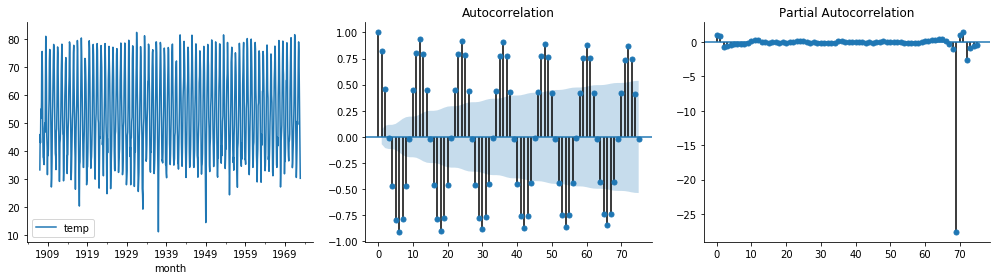

In [23]:
# helper plot for monthly temps
plots(monthly_temp, lags=75);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

In [24]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_temp.temp, 
                                order=(1,1,0), 
                                seasonal_order=(0,1,0,12), 
                                trend='c').fit()
sar.summary()

/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               temp   No. Observations:                  792
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2501.091
Date:                            Tue, 15 Jan 2019   AIC                           5008.183
Time:                                    21:16:01   BIC                           5022.157
Sample:                                01-01-1907   HQIC                          5013.558
                                     - 12-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.216      0.008      0.993      -0.421       0.424
ar.L1         -0.4314      0.029    -14.724      0.000      -0.489      -0.374
sigma2        35.9873      1.517     23.725      0.000      33.014      38.960
===================================================================================
Ljung-Box (Q):                      372.88   Jarque-Bera (JB):                28.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.07
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

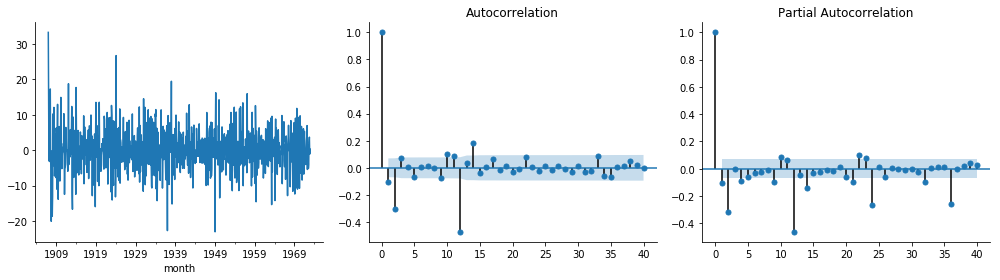

In [25]:
# plot resids
plots(sar.resid, lags=40);

Thought process:  
010010 is overdiff by AIC and negative ACR, but 000010 is a big underdiff with better AIC
we pick 000010,12 and Trend='c' per rule 4/5l

Now look at seasonal. Notice negative ACR spike at 12: per rule 13, we add a SMA term and we see a big drop to 4284 AIC
looks like ACR looks good at seasonal lags, so we move back to ARIMA portion.

Rule 6 says we're a bit underdiff, so we add AR=3 based on PACF: 4261 AIC.

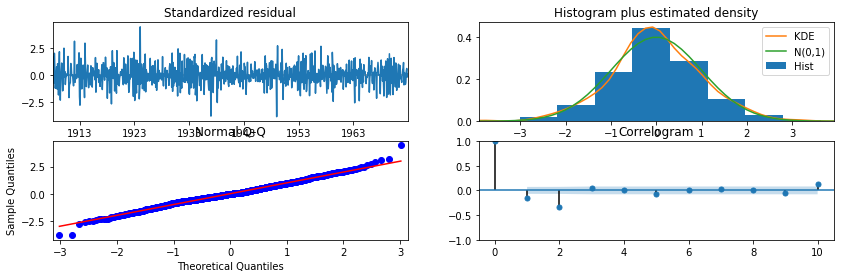

In [26]:
# plot residual diagnostics
sar.plot_diagnostics();

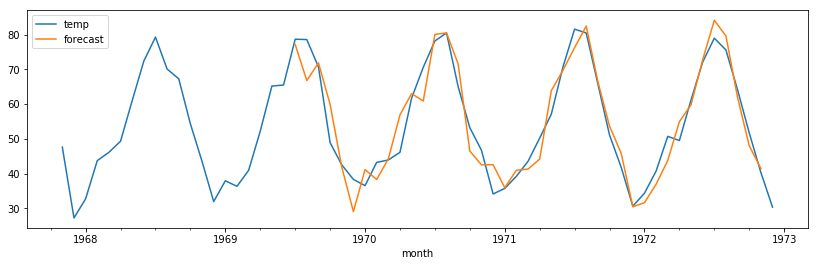

In [27]:
# plot predictions
monthly_temp['forecast'] = sar.predict(start = 750, end= 790, dynamic=False)  
monthly_temp[730:][['temp', 'forecast']].plot();

## Section 3: Statistical Tests


- [Normality (Jarque-Bera)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality)
    - Null hypothesis is normally distributed residuals (good, plays well with RMSE and similar error metrics)

- [Serial correlation (Ljung-Box)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation)
    - Null hypothesis is no serial correlation in residuals (independent of each other)

- [Heteroskedasticity](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity)
    - Tests for change in variance between residuals.
    - The null hypothesis is no heteroskedasticity. That means different things depending on which alternative is selected:
        - Increasing: Null hypothesis is that the variance is not increasing throughout the sample; that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.
        - Decreasing: Null hypothesis is that the variance is not decreasing throughout the sample; that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample.
        - Two-sided (default): Null hypothesis is that the variance is not changing throughout the sample. Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

- [Durbin Watson](https://en.wikipedia.org/wiki/Durbin–Watson_statistic)
    - Tests autocorrelation of residuals: we want between 1-3, 2 is ideal (no serial correlation)

In [28]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]

# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=28.182, p=0.000
Ljung-Box: val=372.879, p=0.000
Heteroskedasticity: val=0.775, p=0.040
Durbin-Watson: d=2.29


### Note on autofit methods
R has an autoARIMA function (and other automagic methods) that gridsearches/optimizes our model hyperparameters for us. Over time, more of these goodies are porting to Python (e.g. statsmodels.tsa.x13 import x13_arima_select_order). While there's nothing wrong with utilizing these resources, the _human makes the final determination!_ Don't become over-reliant on these methods, especially early on when you are grasping the underlying mechanics and theory!

In [29]:
warnings.filterwarnings(action='ignore')

# autoselect for monthly, limited to only searching AR and MA parameters: UPDATE MAX_AR AND MA
autores = sm.tsa.arma_order_select_ic(monthly_temp.temp, 
                                      ic=['aic', 'bic'], 
                                      trend='c', 
                                      max_ar=4, 
                                      max_ma=4, 
                                      fit_kw=dict(method='css-mle'))

print('AIC', autores.aic_min_order) # will use this as inputs for annual
print('BIC', autores.bic_min_order)

('AIC', (2, 3))
('BIC', (2, 3))


In [30]:
# SETUP (using itertools to gridsearch solutions)
import itertools

#set parameter range; feel free to update these!
p = q = range(0, 3)
d = range(0, 2)
season = 12

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
# same for seasonal variant
seasonal_pdq = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))]

print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) , (0, 0, 1, 12)
SARIMAX: (0, 0, 1) , (0, 0, 2, 12)
SARIMAX: (0, 0, 2) , (0, 1, 0, 12)
SARIMAX: (0, 0, 2) , (0, 1, 1, 12)


**Source:* https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [31]:
# APPLY (find optimal ARIMA for annual_

# UNCOMMENT THE FOLLOWING TO RUN (note: this can take awhile)
# warnings.filterwarnings("ignore") # specify to ignore warning messages

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(annual_temp,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('ARIMA{},{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

## Section 4: ARIMA with Pyflux

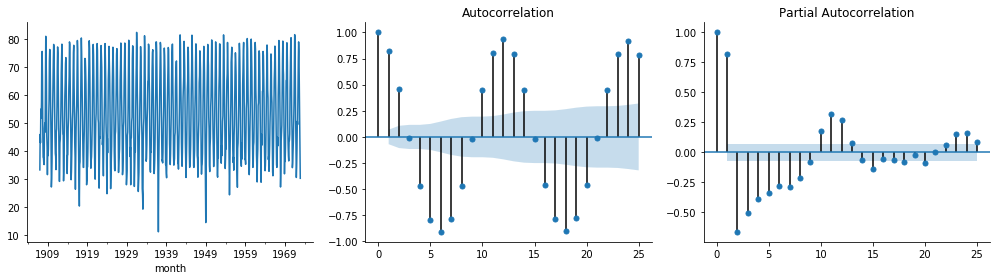

In [32]:
# helper plot
plots(monthly_temp.temp, lags=25)

In [33]:
# build and summarize model
model = pf.ARIMA(data=monthly_temp, ar=2, ma=2, integ=0, target='temp')
x = model.fit("MLE")
x.summary()

Normal ARIMA(2,0,2)                                                                                       
======================================================= ==================================================
Dependent Variable: temp                                Method: MLE                                       
Start Date: 1907-03-01 00:00:00                         Log Likelihood: -2532.4533                        
End Date: 1972-12-01 00:00:00                           AIC: 5076.9067                                    
Number of observations: 790                             BIC: 5104.9389                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 11.6069    0.4414     26.2956  0.0      (10.7418 | 12.4721)      
AR(1)                                

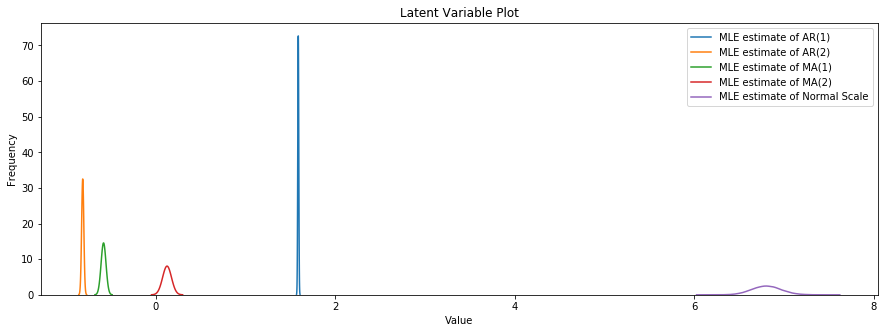

In [34]:
# plot z-scores of feature coefficients
model.plot_z(indices=range(1,9))

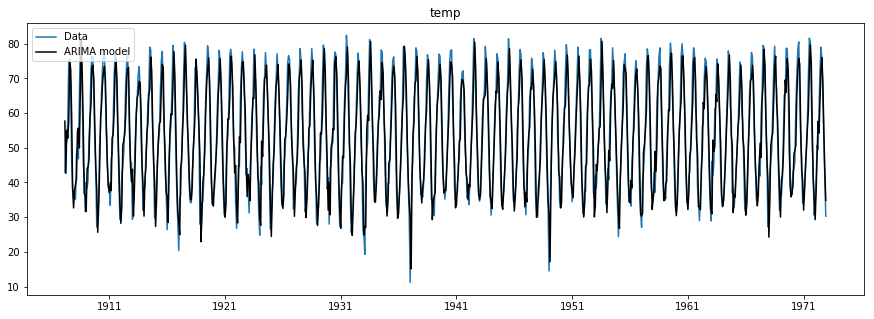

In [35]:
# plot model against raw data
model.plot_fit(figsize=(15,5))

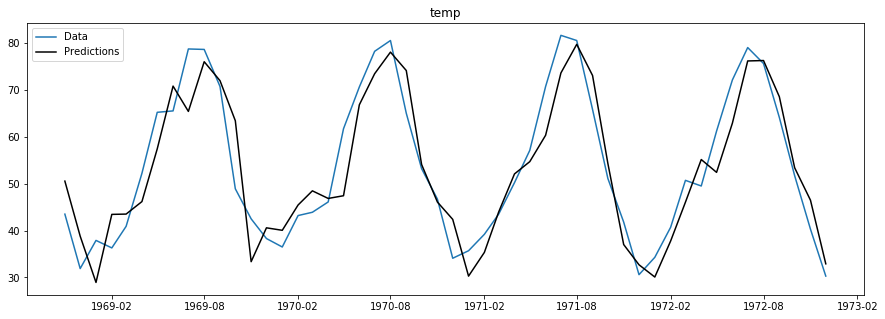

In [36]:
# plot predictions
model.plot_predict_is(50, fit_once=False, figsize=(15,5))

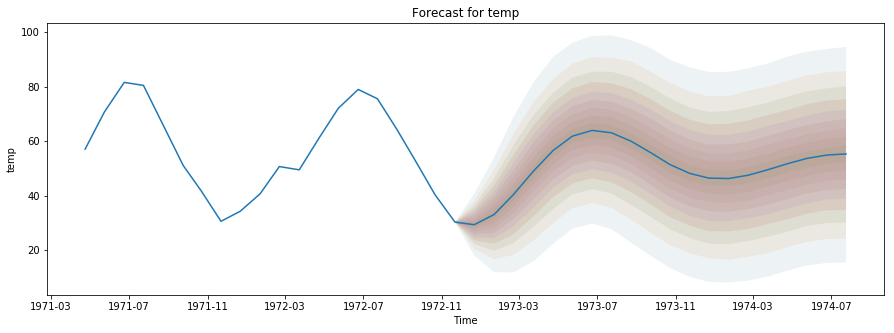

In [37]:
# plot forecast
model.plot_predict(h=20, past_values=20, figsize=(15,5))

### Predicting Sunspots with Pyflux and ARIMA

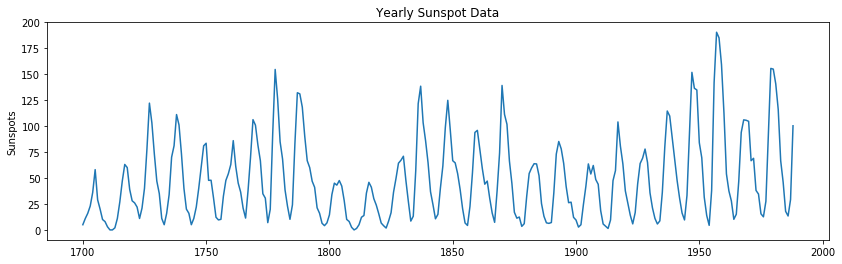

In [38]:
# read and plot data
data_path = 'https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv'
data = pd.read_csv(data_path) #
data.index = data['time'].values

plt.figure()
plt.plot(data.index,data['value'])
plt.ylabel('Sunspots')
plt.title('Yearly Sunspot Data');

In [39]:
# fit and summarize model
model = pf.ARIMA(data=data,ar=4,ma=4,integ=0,target='value')
x = model.fit("MLE")
x.summary()

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: value                               Method: MLE                                       
Start Date: 1704                                        Log Likelihood: -1189.0361                        
End Date: 1988                                          AIC: 2398.0722                                    
Number of observations: 285                             BIC: 2434.5971                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 7.5502     2.7733     2.7224   0.0065   (2.1145 | 12.986)        
AR(1)                                

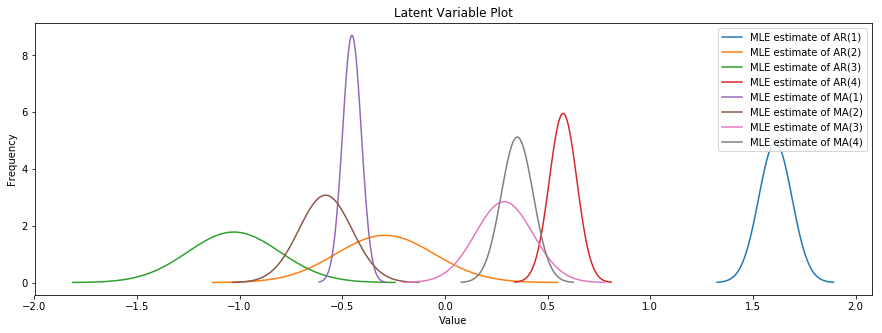

In [40]:
# plot z-scores of feature coefficients
model.plot_z(indices=range(1,9))

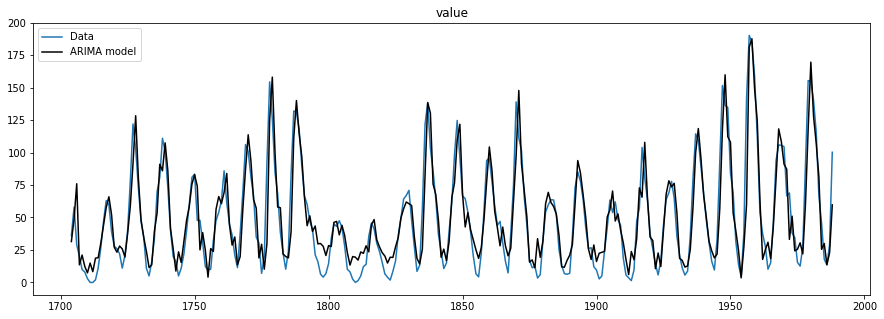

In [41]:
# plot model
model.plot_fit(figsize=(15,5))

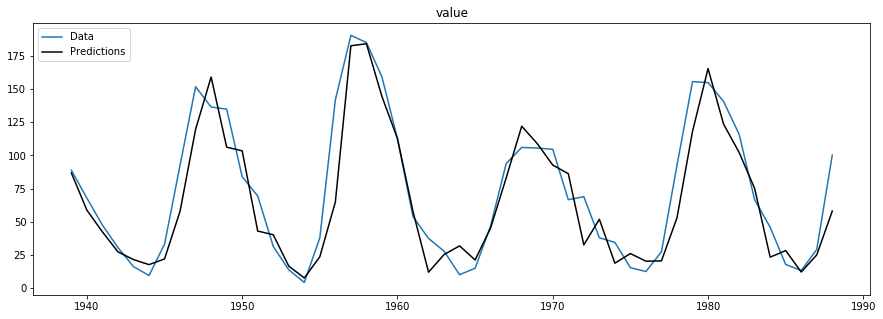

In [42]:
# plot in sample
model.plot_predict_is(50, figsize=(15,5))

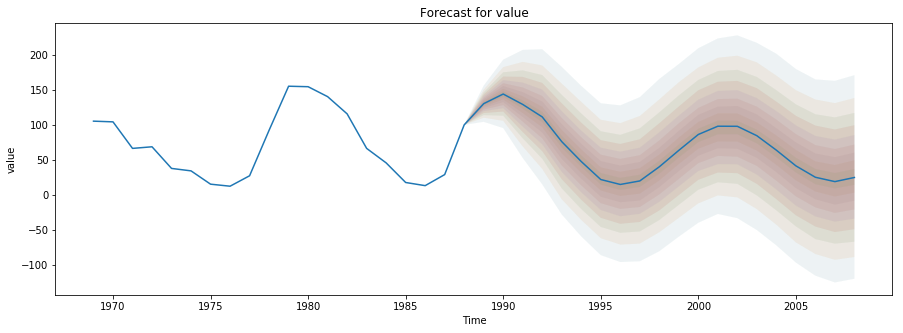

In [43]:
# plot forecast
model.plot_predict(h=20,past_values=20, figsize=(15,5))

## Section 5: Statsmodels - CO2 Levels and Forecasting
Let's look at sensor data that tracks atmospheric CO2 from continuous air samples at Mauna Loa Observatory in Hawaii. This data includes CO2 samples from MAR 1958 to DEC 2001.

[Credits](https://www.digitalocean.com/community/users/tvincent) 

In [44]:
# load data
co2 = pd.read_csv('../Data/co2-ppm-mauna-loa-19651980.csv', 
                  header = 0,
                  names = ['idx', 'co2'],
                  skipfooter = 2)
co2 = co2.drop('idx', 1)

# recast co2 col to float
co2['co2'] = pd.to_numeric(co2['co2'])
co2.drop(labels=0, inplace=True)

# set index
index = pd.date_range('1/1/1965', periods=191, freq='M')
co2.index = index

In [45]:
co2.head()

,co2
1965-01-31,320.36
1965-02-28,320.82
1965-03-31,322.06
1965-04-30,322.17
1965-05-31,321.95


In [46]:
# resample to monthly and check missing values
co2 = co2['co2'].resample('M').mean()

co2 = co2.fillna(co2.bfill())
print("Nulls:", co2.isnull().sum())

('Nulls:', 0)


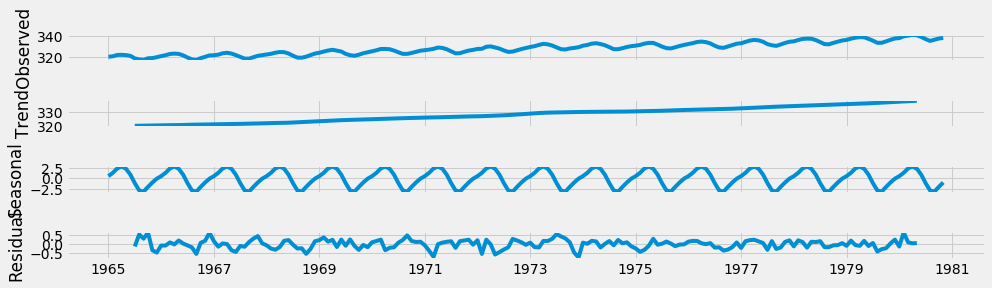

In [47]:
# decompose data into trend, seasonal, and residual
plt.style.use('fivethirtyeight')
decomposition = sm.tsa.seasonal_decompose(co2, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# optimize our SARIMAX model using itertools: CAREFUL, this can take a while
# warnings.filterwarnings("ignore") # specify to ignore warning messages

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             model = sm.tsa.statespace.SARIMAX(co2, order=param,
#                         seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False).fit()

#             print('ARIMA{},{} - AIC:{}'.format(param, param_seasonal, model.aic))
#         except:
#             continue

In [48]:
# build model
co2sar = sm.tsa.statespace.SARIMAX(co2, order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
co2sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                co2   No. Observations:                  191
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -44.578
Date:                            Tue, 15 Jan 2019   AIC                             99.155
Time:                                    21:20:59   BIC                            114.654
Sample:                                01-31-1965   HQIC                           105.447
                                     - 11-30-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3561      0.226      1.572      0.116      -0.088       0.800
ma.L1         -0.6332      0.193     -3.280      0.001      -1.012      -0.255
ar.S.L12      -0.0978      0.102     -0.963      0.336      -0.297       0.101
ma.S.L12      -0.7499      0.101     -7.427      0.000      -0.948      -0.552
sigma2         0.0954      0.009     10.830      0.000       0.078       0.113
===================================================================================
Ljung-Box (Q):                       35.89   Jarque-Bera (JB):                 8.37
Prob(Q):                              0.66   Prob(JB):                         0.02
Heteroskedasticity (H):               1.12   Skew:                             0.29
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

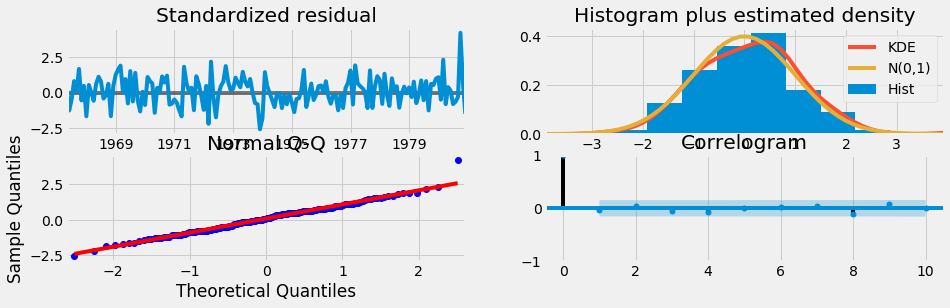

In [49]:
# check diagnostics
co2sar.plot_diagnostics();

In [50]:
# create predictions and confidence intervals
pred = co2sar.get_prediction(start=pd.to_datetime('1979-4-30'), dynamic=False) # we use as many true values as possible to predict
pred_ci = pred.conf_int()

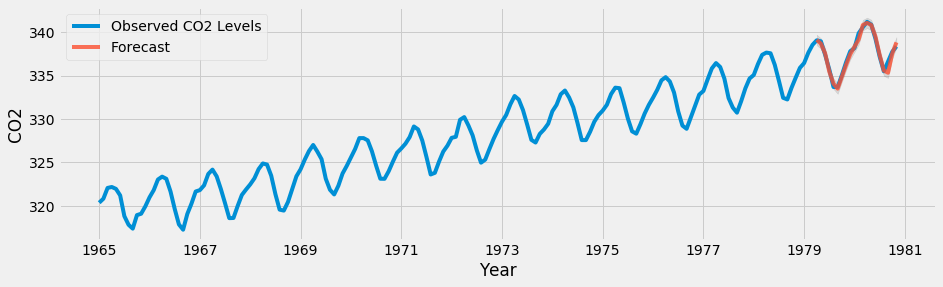

In [51]:
# plot predictions
ax = co2.plot(label='Observed CO2 Levels')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.8) # this is using all available info

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Year')
ax.set_ylabel('CO2')
plt.legend()

plt.show();

In [52]:
# compute mean square error
fcast = pred.predicted_mean
true = co2['1979-4-30':]

mse = ((fcast - true) ** 2).mean()
print('MSE of our forecasts is {}'.format(round(mse, 3)))

MSE of our forecasts is 0.163


In [53]:
# dynamic forecast
fcast = co2sar.get_prediction(start=pd.to_datetime('1979-4-30'), dynamic=True, full_results=True)
fcast_ci = fcast.conf_int()

# caution: this is modeling assumptions on top of assumptions

In [54]:
fcast_ci

,lower co2,upper co2
1979-04-30,338.506172,339.717216
1979-05-31,337.974755,339.469095
1979-06-30,336.579173,338.253845
1979-07-31,334.533212,336.353509
1979-08-31,332.888108,334.837735
1979-09-30,332.562408,334.631492
1979-10-31,333.722281,335.903683
1979-11-30,334.898458,337.186464
1979-12-31,335.895196,338.284990
1980-01-31,336.480705,338.968101


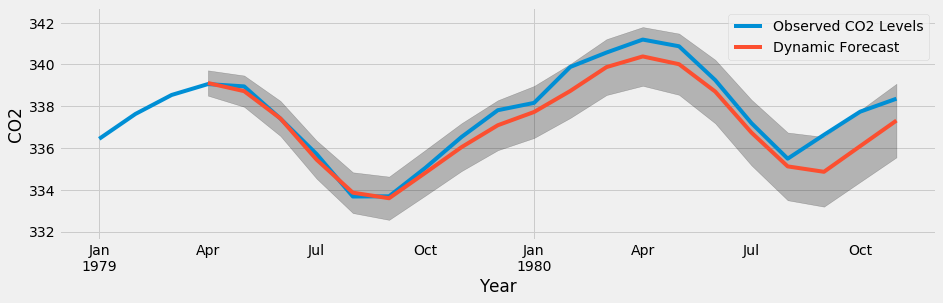

In [55]:
# plot predictions
ax = co2['1979':].plot(label='Observed CO2 Levels')
fcast.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(fcast_ci.index, fcast_ci.iloc[:, 0],
                fcast_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1980-11-30'), co2.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Year')
ax.set_ylabel('CO2')

plt.legend()
plt.show()

In [56]:
# compute mean square error
fcast_avg = fcast.predicted_mean
true = co2['1979-4-30':]

mse = ((fcast_avg - true) ** 2).mean()
print('MSE is {}'.format(round(mse, 3)))

# notice it's much higher

MSE is 0.597


In [57]:
# forecast next 100 months and get confidence interval
pred_uc = co2sar.get_forecast(steps=100)

pred_ci = pred_uc.conf_int()

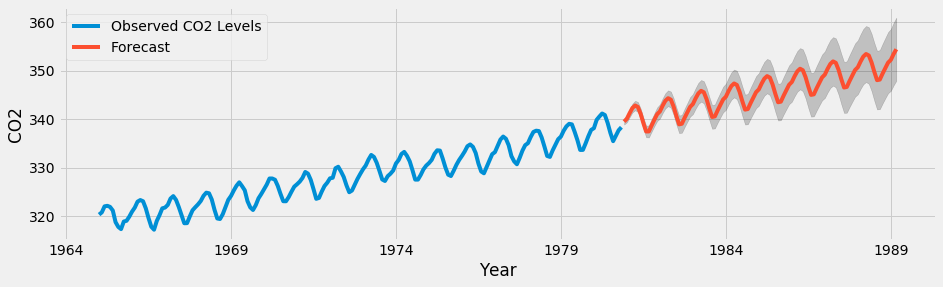

In [58]:
# plot forecast
ax = co2[:].plot(label='Observed CO2 Levels')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('CO2')

plt.legend()
plt.show()

# Section 6: Predicting with [Facebook](https://facebookincubator.github.io/prophet/) [Prophet](https://research.fb.com/prophet-forecasting-at-scale/)

From site:

> Today Facebook is open sourcing Prophet, a forecasting tool available in Python and R. Forecasting is a data science task that is central to many activities within an organization. For instance, large organizations like Facebook must engage in capacity planning to efficiently allocate scarce resources and goal setting in order to measure performance relative to a baseline. Producing high quality forecasts is not an easy problem for either machines or for most analysts. We have observed two main themes in the practice of creating a variety of business forecasts:
- Completely automatic forecasting techniques can be brittle and they are often too inflexible to incorporate useful assumptions or heuristics.
- Analysts who can produce high quality forecasts are quite rare because forecasting is a specialized data science skill requiring substantial experience.

Prophet is an additive regression model that includes a number of highly advanced, intelligent [forecasting methods](http://andrewgelman.com/2017/03/01/facebooks-prophet-uses-stan/), including [changepoint analysis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=0ahUKEwjpwM_JhsbVAhWNxIMKHSWqD6kQFgguMAE&url=http%3A%2F%2Fwww.variation.com%2Fcpa%2Ftech%2Fchangepoint.html&usg=AFQjCNFK6wbwWuBCixZJHu03LkABXL3UHA):

- A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
- A yearly seasonal component modeled using Fourier series.
- A weekly seasonal component using dummy variables.
- A user-provided list of important holidays.

And because it's built in [Stan](http://mc-stan.org/), it's very fast, and funcionality/code translates easily between R and Python!

Prophet is optimized for the business forecast tasks we have encountered at Facebook, which typically have any of the following characteristics:

- Hourly, daily, or weekly observations with at least a few months (preferably a year) of history
- Strong multiple “human-scale” seasonalities: day of week and time of year
- Important holidays that occur at irregular intervals that are known in advance
- A reasonable number of missing observations or large outliers
- Historical trend changes, for instance due to product launches or logging changes
- Trends that are non-linear growth curves, where a trend hits a natural limit or saturates

[Technical details behind prophet](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf): built around a generalized additive model (GAM)

More [GAM background](http://www.stat.cmu.edu/~cshalizi/350/lectures/21/lecture-21.pdf):

This includes the linear model as a special case, where fj(xj) = βjxj, but it’s clearly more general, because the fjs can be pretty arbitrary nonlinear functions. The idea is still that each input feature makes a separate contribution to the response, and these just add up, but these contributions don’t have to be strictly proportional to the inputs. We do need to add a restriction to make it identifiable; without loss of generality, say that E [Y ] = α and E [fj (Xj )] = 0.3
Additive models keep a lot of the nice properties of linear models, but are more flexible. One of the nice things about linear models is that they are fairly straightforward to interpret: if you want to know how the prediction changes as you change xj, you just need to know βj. The partial response function fj plays the same role in an additive model: of course the change in prediction from changing xj will generally depend on the level xj had before perturbation, but since that’s also true of reality that’s really a feature rather than a bug.

In [60]:
!pip install fbprophet

    100% |████████████████████████████████| 51kB 754kB/s ta 0:00:01
    100% |████████████████████████████████| 52.1MB 70kB/s eta 0:00:011
    100% |████████████████████████████████| 71kB 121kB/s eta 0:00:01
    100% |████████████████████████████████| 747kB 2.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for fbprophet ... error
  Complete output from command /anaconda2/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/w9/cv0lh9lj3_79503qn1046m_00000gn/T/pip-install-X8UBlv/fbprophet/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /private/var/folders/w9/cv0lh9lj3_79503qn1046m_00000gn/T/pip-wheel-nhYVz2 --python-tag cp27:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creating build/lib/fbprophet
  creating build/lib/fbprophet/stan_model
  Traceback (most recent call last):
    File "<string>", line 1, in 

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [63]:
# read daily page views for the Wikipedia page for Peyton Manning; scraped into hosted CSV
#conda install -c conda-forge fbprophet #(to install)
from fbprophet import Prophet

data_path = 'https://raw.githubusercontent.com/PinkWink/DataScience/master/data/07.%20example_wp_peyton_manning.csv'
peyton = pd.read_csv(data_path)

ImportError: No module named fbprophet

In [ ]:
# plot data
peyton.plot()
plt.grid();

In [ ]:
# log data due to spikes
peyton['y'] = np.log(peyton['y'])
peyton.head()

In [ ]:
# plot log
peyton.plot()
plt.grid();

In [ ]:
# fit model
m = Prophet()
m.fit(peyton)

In [ ]:
# forecast 365 days into future
future = m.make_future_dataframe(periods=365)
future.tail()

In [ ]:
# populate forecast
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# plot forecast
m.plot(forecast);

In [ ]:
# plot individual components of forecast: trend, weekly/yearly seasonality,
m.plot_components(forecast);

>We can also add holiday and Superbowl date information to Peyton's forecast, since we hypothesize people will visit his site more often on those dates.

In [ ]:
# add holidays 
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0, # these help us specify spillover into previous and future days
  'upper_window': 1,
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, superbowls))

In [ ]:
# fit and predict
m = Prophet(holidays=holidays)
forecast = m.fit(peyton).predict(future)

In [ ]:
# we can see the effects of various 'holidays' on site visits
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

In [ ]:
# check the impacts visually
m.plot_components(forecast);

>Peyton won Superbowls XLI (41, 2007) and 50 (2016), while losing XLIV (44, 2010) and XLVIII(48, 2014). We can see these spikes in the holidays chart.

### Predicting CO2

In [ ]:
# load data
co2 = pd.read_csv('../Data/co2-ppm-mauna-loa-19651980.csv', 
                  header = 0,
                  names = ['idx', 'co2'],
                  skipfooter = 2)
co2 = co2.drop('idx', 1)

# recast co2 col to float
co2['co2'] = pd.to_numeric(co2['co2'])
co2.drop(labels=0, inplace=True)

# set index
index = pd.date_range('1/1/1965', periods=191, freq='M')
co2.index = index

In [ ]:
# load co2 data, rename headers, and check
# data = sm.datasets.co2.load_pandas()
# co2 = data.data

co2['ds'] = co2.index
co2.rename(columns={'co2': 'y'}, inplace=True)

co2.tail()

In [ ]:
# fit model
model = Prophet()
model.fit(co2);

In [ ]:
# forecast 15 years into future
future = model.make_future_dataframe(periods=120, freq='M', include_history=True)
future.tail()

#future = model.make_future_dataframe(periods=365*15)
#future.tail()

In [ ]:
# populate forecast
forecast = model.predict(future)
forecast.tail()

In [ ]:
model.plot(forecast);

In [ ]:
# plot individual components of forecast: trend, weekly/yearly seasonality,
model.plot_components(forecast);

In [ ]:
# we can add a cap to limit our theoretical growth
co2['cap'] = 380
m = Prophet(growth='logistic')
m.fit(co2);

# forecast 15 years into future with cap of 380
future = m.make_future_dataframe(periods=365*15, include_history=False)
future['cap'] = 380

forecast = m.predict(future)
m.plot(forecast);

---

# Summary
In this notebook you should have gained: 
1. A practical understanding of Autoregressive Moving Average (ARMA) models.
2. A basic understanding of the Autocorrelation Function (ACF).
3. Insight into choosing the order *q* of MA models.
4. A practical understanding of Autoregressive (AR) models.
5. A basic understanding of the Partial Autocorrelation Function (PACF).
6. Insight into choosing the order *p* of AR models.

Congratulations, that concludes this lesson.